In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Params
img_size = 224
batch_size = 32
num_classes = 10

# Paths
train_dir = r"C:\Users\Dell\Desktop\Music-Classification-MobileNet1\project_data\train_spectrograms"
test_dir = r"C:\Users\Dell\Desktop\Music-Classification-MobileNet1\project_data\test_spectrograms"

# Train/val generators (80/20 split)
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


print("Train:")
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

print("Val:")
val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Test generator (no split)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Test:")
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Train:
Found 766 images belonging to 10 classes.
Val:
Found 188 images belonging to 10 classes.
Test:
Found 355 images belonging to 10 classes.


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import os


# Model setup
base_model = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)        # Flatten conv output
x = Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision()])

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25
)

# Save model
name_model="models/mobilenet_dense256_DO05.keras"
model.save(name_model)

# Test evaluation
print("\nTesting -------------------------------")
results = model.evaluate(test_generator)

# Indeksy: [0] = loss, [1] = accuracy, [2] = precision
test_loss = results[0]
test_acc = results[1]
test_precision = results[2]

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2%}")
print(f"Test Precision: {test_precision:.2%}")

c:\Users\Dell\AppData\Local\pypoetry\Cache\virtualenvs\music-classification-1IWzNP0M-py3.12\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 28s 971ms/step - accuracy: 0.2277 - loss: 2.4211 - precision: 0.3117 - val_accuracy: 0.3457 - val_loss: 1.6769 - val_precision: 0.7805
Epoch 2/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 665ms/step - accuracy: 0.4734 - loss: 1.5127 - precision: 0.8182 - val_accuracy: 0.3883 - val_loss: 1.4766 - val_precision: 0.8333
Epoch 3/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 650ms/step - accuracy: 0.5750 - loss: 1.2102 - precision: 0.7531 - val_accuracy: 0.4362 - val_loss: 1.5519 - val_precision: 0.6747
Epoch 4/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 636ms/step - accuracy: 0.5867 - loss: 1.1924 - precision: 0.7217 - val_accuracy: 0.5106 - val_loss: 1.3618 - val_precision: 0.7363
Epoch 5/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 634ms/step - accuracy: 0.6482 - loss: 1.0214 - precision: 0.7842 - val_accuracy: 0.5106 - val_loss: 1.3728 - val_precision: 0.6699
Epoch 6/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 643ms/step - accuracy: 0.7002 - loss: 0.8944 - precision: 0.8290 - val_accuracy: 0.4574 - val

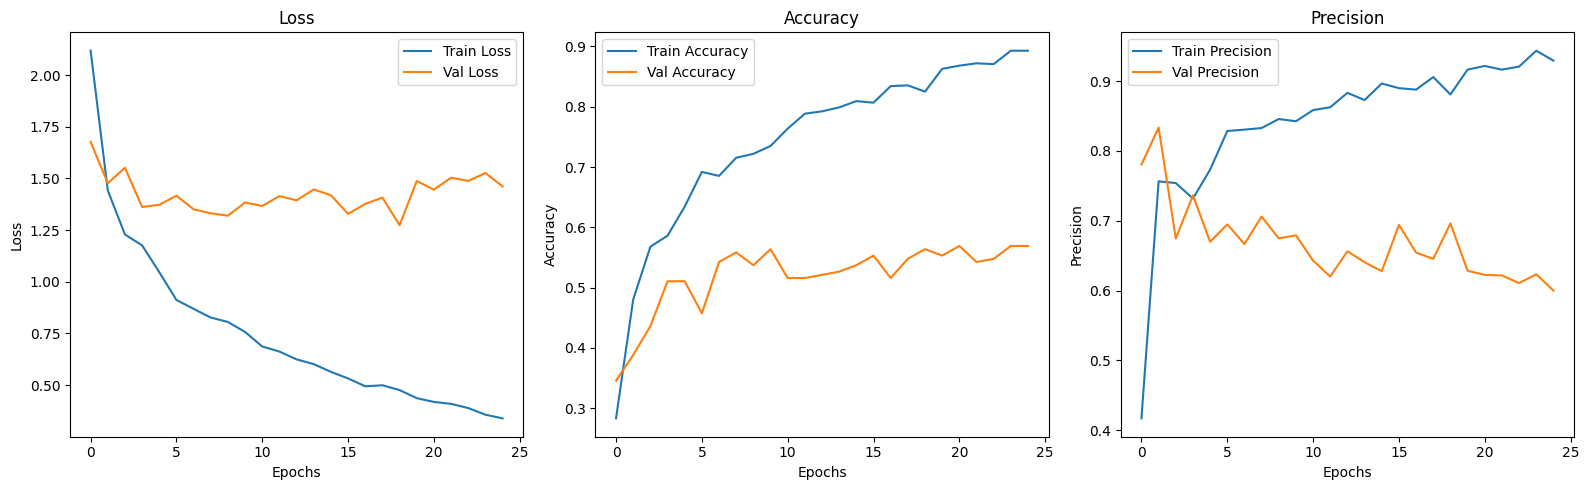

In [3]:
from mobilenet_utils import plot_training_history

plot_training_history(history)

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 703ms/step


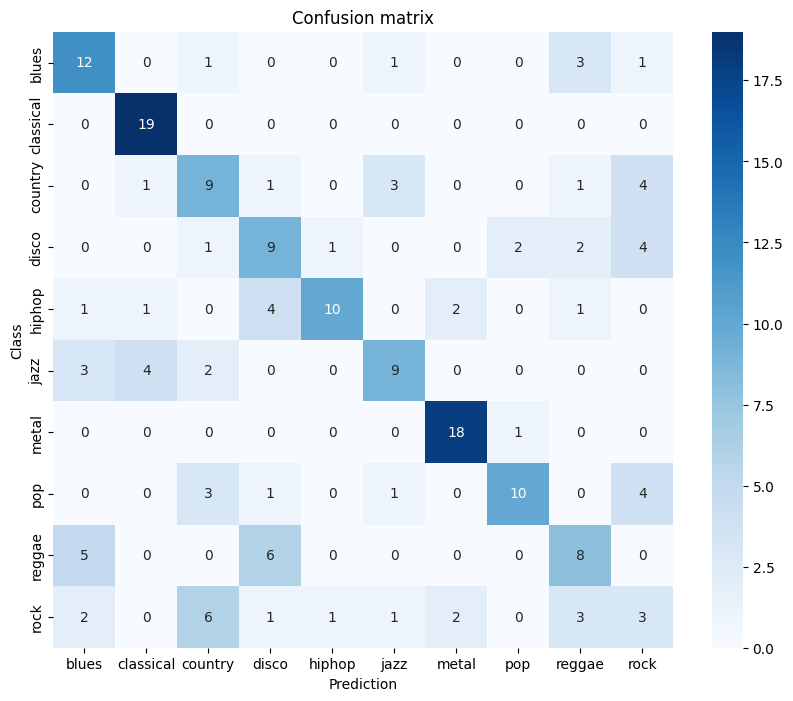

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import numpy as np

# Generujemy predykcje
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Prawdziwe etykiety
y_true = val_generator.classes

# Nazwy klas
class_labels = list(val_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Prediction")
plt.ylabel("Class")
plt.title("Confusion matrix")
plt.show()